In [1]:
'''!pip install matplotlib
!pip install seaborn
!pip install plotly.express

!pip install numpy
!pip install pandas
!pip install nbformat
!pip install sklearn
!pip install scikit-learn'''

'!pip install matplotlib\n!pip install seaborn\n!pip install plotly.express\n\n!pip install numpy\n!pip install pandas\n!pip install nbformat\n!pip install sklearn\n!pip install scikit-learn'

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

from scipy import stats

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
def inspect_values(df: pd.DataFrame) -> None:
    '''
    extensive overview of data
    '''
    for column in df.columns:
        print(f"column: {column}", end=' - ')
        if (df[column].dtype not in ['float64', 'int64', 'datetime64[ns]']) or (df[column].nunique() < 15):
            print(f"unique values: {df[column].unique()}", end=' - ')
        else:
            print(f"values: from {min(df[column])} to {max(df[column])}", end=' - ')
        print(f"datatype: {df[column].dtype}" , end=' - ')
        print('number of NaN values:', df[column].isna().sum())

In [5]:
clients = pd.read_csv('data/train/client_train.csv', low_memory=False, parse_dates=True)
invoices = pd.read_csv('data/train/invoice_train.csv', low_memory=False, parse_dates=True)

In [6]:
## Baseline model

# A customer with exceptional fluctuations in monthly (or yearly??) consommation is likely to be a fraud. 
# If the clients STD is higher than the mean STD of all clients, they will be flagged as fraud. 
# OR: id STD is in top 5% of all clients 


baseline = invoices.copy()

baseline.eval('total_consommation = consommation_level_1 + consommation_level_2 + consommation_level_3 + consommation_level_4', inplace=True)
baseline.head()

base_grouped = baseline.groupby('client_id').total_consommation.std().reset_index()
base_grouped.head()

mean_std = base_grouped.total_consommation.mean()
mean_std

base_grouped['target_baseline'] = base_grouped.total_consommation > mean_std
base_grouped.head()

,client_id,total_consommation,target_baseline
0,train_Client_0,341.553930,False
1,train_Client_1,197.935960,False
2,train_Client_10,646.808386,True
3,train_Client_100,3.607011,False
4,train_Client_1000,633.485669,True


Metric (AUC):  0.5775814701898836


<Axes: >

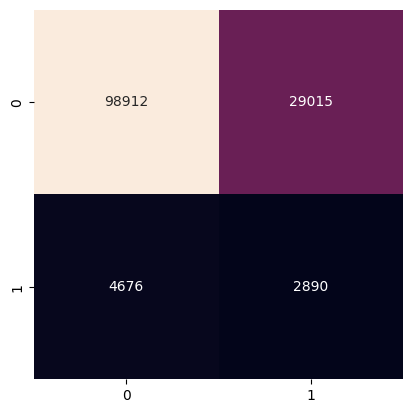

In [7]:
## how good is baseline model?

clients_baseline = pd.merge(left=clients, right=base_grouped.drop(columns='total_consommation', axis=1), on='client_id')

print('Metric (AUC): ', roc_auc_score(clients_baseline.target, clients_baseline.target_baseline))
sns.heatmap(confusion_matrix(clients_baseline.target, clients_baseline.target_baseline), square=True, annot=True, fmt='d', cbar=False)



Milestone 1 (Vadym and Vanessa): \
Fraud Detection: \
Value of Product: \
Find fraudulent transactions, safe money, avoid reputation damage and prevent money laundering. \
Prediction: \
Detect anomalies in client's energy consummation behavior \
Evaluation Metric: \
AUC (recommended and given by Zindi) \
Baseline Model: \
A customer with exceptional fluctuations in monthly consummation is likely to be a fraud. \
If the clients' standard deviation of total consummation is higher than the average STD of all clients, they will be flagged as fraud. \
Score: \ 
AUC = 0.5776

In [8]:
inspect_values(clients)

column: disrict - unique values: [60 69 62 63] - datatype: int64 - number of NaN values: 0
column: client_id - unique values: ['train_Client_0' 'train_Client_1' 'train_Client_10' ...
 'train_Client_99997' 'train_Client_99998' 'train_Client_99999'] - datatype: object - number of NaN values: 0
column: client_catg - unique values: [11 12 51] - datatype: int64 - number of NaN values: 0
column: region - values: from 101 to 399 - datatype: int64 - number of NaN values: 0
column: creation_date - unique values: ['31/12/1994' '29/05/2002' '13/03/1986' ... '16/08/2004' '30/08/1978'
 '25/05/1978'] - datatype: object - number of NaN values: 0
column: target - unique values: [0. 1.] - datatype: float64 - number of NaN values: 0


In [9]:
inspect_values(invoices)

column: client_id - unique values: ['train_Client_0' 'train_Client_1' 'train_Client_10' ...
 'train_Client_99997' 'train_Client_99998' 'train_Client_99999'] - datatype: object - number of NaN values: 0
column: invoice_date - unique values: ['2014-03-24' '2013-03-29' '2015-03-23' ... '1995-11-28' '1982-07-04'
 '1996-09-02'] - datatype: object - number of NaN values: 0
column: tarif_type - values: from 8 to 45 - datatype: int64 - number of NaN values: 0
column: counter_number - values: from 0 to 27981145458733 - datatype: int64 - number of NaN values: 0
column: counter_statue - unique values: ['0' '1' '5' '4' '3' '2' '769' 'A' '618' '269375' '46' '420'] - datatype: object - number of NaN values: 0
column: counter_code - values: from 0 to 600 - datatype: int64 - number of NaN values: 0
column: reading_remarque - unique values: [  8   6   9   7 207 413 203   5] - datatype: int64 - number of NaN values: 0
column: counter_coefficient - values: from 0 to 50 - datatype: int64 - number of NaN v

In [10]:
# px.histogram(invoices[invoices['months_number'] < 12], x='months_number', histfunc='count')

In [11]:
invoices['total_consommation'] = invoices.eval("consommation_level_1 + consommation_level_2 + consommation_level_3 + consommation_level_4")

In [12]:
invoices_grouped = invoices.groupby('client_id').mean(numeric_only=True)
invoices_grouped.rename(mapper={'total_consommation': 'mean_total_consommation'}, axis=1, inplace=True)
invoices_grouped = invoices_grouped.reset_index()
invoices_grouped.head(10)


,client_id,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,mean_total_consommation
0,train_Client_0,11.000000,1.335667e+06,203.685714,6.971429,1.0,352.400000,10.571429,0.000000,0.000000,9444.542857,9807.514286,4.628571,362.971429
1,train_Client_1,11.000000,6.789020e+05,203.000000,7.216216,1.0,557.540541,0.000000,0.000000,0.000000,14330.756757,14888.297297,4.324324,557.540541
2,train_Client_10,11.000000,5.727650e+05,203.222222,7.055556,1.0,798.611111,37.888889,0.000000,0.000000,32873.000000,33709.500000,6.444444,836.500000
3,train_Client_100,11.000000,2.078000e+03,413.000000,6.150000,1.0,1.200000,0.000000,0.000000,0.000000,94.150000,95.350000,4.200000,1.200000
4,train_Client_1000,11.000000,1.957500e+04,207.000000,8.857143,1.0,663.714286,104.857143,117.357143,36.714286,6900.428571,7823.071429,3.714286,922.642857
5,train_Client_10000,22.479167,8.149729e+05,124.625000,7.708333,1.0,352.104167,10.437500,3.770833,0.000000,13789.625000,14155.937500,4.000000,366.312500
6,train_Client_100000,25.500000,4.446350e+04,209.000000,7.975000,1.0,280.025000,6.550000,0.000000,0.000000,19788.750000,20075.325000,3.700000,286.575000
7,train_Client_100001,25.128205,5.904181e+05,106.538462,7.025641,1.0,327.500000,0.923077,0.000000,0.000000,6583.141026,6911.564103,3.871795,328.423077
8,train_Client_100002,11.000000,1.441290e+05,413.000000,7.500000,1.0,112.500000,0.000000,0.000000,0.000000,3.500000,116.000000,4.000000,112.500000
9,train_Client_100003,11.000000,5.868000e+05,467.000000,9.000000,1.0,850.800000,1629.200000,320.000000,4882.000000,9342.200000,17024.200000,4.000000,7682.000000


In [36]:
agg_clients = pd.merge(left=clients, right=invoices_grouped[['client_id', 'mean_total_consommation']], how='left')

In [37]:
count_num = invoices.groupby('client_id').counter_number.nunique().to_frame('number_of_counter_numbers').reset_index()

agg_clients = pd.merge(left=agg_clients, right=count_num, on='client_id')

del count_num

In [38]:
counter_dict = {'A': 0, '0': 0, '1': 1, '5': 5, '4': 4, '3': 3, '2': 2, '769': 0, '618': 0, '269375': 0, '46': 0, '420': 0}
invoices.counter_statue = invoices.counter_statue.map(lambda x: counter_dict.get(x, x))

invoices.counter_statue.unique()

array([0, 1, 5, 4, 3, 2])

In [39]:
df = pd.merge(left=clients, right=invoices, on='client_id', how='left')

counter_statues = df.groupby('client_id').counter_statue.apply(stats.mode).apply(lambda x: x[0]).to_frame('mode_counter_statue').reset_index()
agg_clients = pd.merge(left=agg_clients, right=counter_statues, on='client_id')

del counter_statues

In [17]:
df.groupby(['reading_remarque', 'target']).size()

reading_remarque  target
5                 0.0             1
6                 0.0       2059001
                  1.0        171938
7                 0.0           660
                  1.0             1
8                 0.0        760354
                  1.0         67769
9                 0.0       1303588
                  1.0        113404
203               0.0            15
207               0.0             6
413               0.0            12
dtype: int64

In [40]:
remarque_dict = {5: 6, 207: 6, 413: 6, 203: 6}
invoices.reading_remarque = invoices.reading_remarque.map(lambda x: remarque_dict.get(x, x))

invoices.reading_remarque.unique()

array([8, 6, 9, 7])

In [41]:
reading_mode = invoices.groupby('client_id').reading_remarque.apply(stats.mode).apply(lambda x: x[0]).to_frame('mode_reading_remarque').reset_index()
agg_clients = pd.merge(left=agg_clients, right=reading_mode, on='client_id')

In [42]:
min_max = invoices.groupby('client_id').total_consommation.aggregate(['min', 'max'])
rng_total_consommation = min_max.apply(lambda x: x.to_list()[1] - x.to_list()[0], axis=1).to_frame('range_total_consommation').reset_index()

agg_clients = pd.merge(left=agg_clients, right=rng_total_consommation, on='client_id')

In [43]:
invoices.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,total_consommation,diff_index,count_mismatch_per_invoice,con_ind_mismatch
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC,82,82,False,False
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC,1384,1384,False,False
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC,123,123,False,False
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC,102,102,False,False
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC,572,572,False,False


In [44]:
invoices['invoice_date'] = pd.to_datetime(invoices['invoice_date'])

invoices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 20 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   client_id                   object        
 1   invoice_date                datetime64[ns]
 2   tarif_type                  int64         
 3   counter_number              int64         
 4   counter_statue              int64         
 5   counter_code                int64         
 6   reading_remarque            int64         
 7   counter_coefficient         int64         
 8   consommation_level_1        int64         
 9   consommation_level_2        int64         
 10  consommation_level_3        int64         
 11  consommation_level_4        int64         
 12  old_index                   int64         
 13  new_index                   int64         
 14  months_number               int64         
 15  counter_type                object        
 16  total_consommation

In [45]:
# how long has customer been a customer? range between first and last date per client_id

minmax_date = invoices.groupby('client_id').invoice_date.aggregate(['min','max']).reset_index()

minmax_date['date_interval'] =((minmax_date['max'] - minmax_date['min']) / np.timedelta64(1, 'W')).astype('int')


agg_clients = pd.merge(left=agg_clients, right=minmax_date[['client_id', 'date_interval']], on='client_id')
agg_clients.head()

,disrict,client_id,client_catg,region,creation_date,target,mean_total_consommation,number_of_counter_numbers,mode_counter_statue,mode_reading_remarque,range_total_consommation,date_interval
0,60,train_Client_0,11,101,31/12/1994,0.0,362.971429,1,0,6,1348,700
1,69,train_Client_1,11,107,29/05/2002,0.0,557.540541,1,0,6,1017,701
2,62,train_Client_10,11,301,13/03/1986,0.0,836.500000,1,0,6,2894,703
3,69,train_Client_100,11,105,11/07/1996,0.0,1.200000,1,0,6,15,380
4,62,train_Client_1000,11,303,14/10/2014,0.0,922.642857,1,0,9,2258,226


In [46]:
# does a client have only electricity, or gas too?

gaz_type = invoices.groupby('client_id').counter_type.aggregate(['max']).reset_index()

#gaz_type

gaz_dict = {'ELEC': 0, 'GAZ':1}
gaz_type['has_gaz'] = gaz_type['max'].map(gaz_dict)

agg_clients = pd.merge(left=agg_clients, right=gaz_type.drop('max', axis=1), on='client_id')
agg_clients.head()


,disrict,client_id,client_catg,region,creation_date,target,mean_total_consommation,number_of_counter_numbers,mode_counter_statue,mode_reading_remarque,range_total_consommation,date_interval,has_gaz
0,60,train_Client_0,11,101,31/12/1994,0.0,362.971429,1,0,6,1348,700,0
1,69,train_Client_1,11,107,29/05/2002,0.0,557.540541,1,0,6,1017,701,0
2,62,train_Client_10,11,301,13/03/1986,0.0,836.500000,1,0,6,2894,703,0
3,69,train_Client_100,11,105,11/07/1996,0.0,1.200000,1,0,6,15,380,0
4,62,train_Client_1000,11,303,14/10/2014,0.0,922.642857,1,0,9,2258,226,0


In [25]:
# TODO
# clean up
# rm or delete or del  unneeded dataframes

# new feature: is total consommation equal to difference in new_index and old_index?


In [47]:
agg_clients.head()

,disrict,client_id,client_catg,region,creation_date,target,mean_total_consommation,number_of_counter_numbers,mode_counter_statue,mode_reading_remarque,range_total_consommation,date_interval,has_gaz
0,60,train_Client_0,11,101,31/12/1994,0.0,362.971429,1,0,6,1348,700,0
1,69,train_Client_1,11,107,29/05/2002,0.0,557.540541,1,0,6,1017,701,0
2,62,train_Client_10,11,301,13/03/1986,0.0,836.500000,1,0,6,2894,703,0
3,69,train_Client_100,11,105,11/07/1996,0.0,1.200000,1,0,6,15,380,0
4,62,train_Client_1000,11,303,14/10/2014,0.0,922.642857,1,0,9,2258,226,0


In [48]:
std_consommation = invoices.groupby('client_id').total_consommation.std().reset_index()
std_consommation.rename(mapper={'total_consommation': 'std_total_consommation'}, axis=1, inplace=True)
agg_clients = pd.merge(left=agg_clients, right=std_consommation, on='client_id')


In [28]:
# TODO: has both elec and gaz

In [29]:
agg_clients.head(10)

,disrict,client_id,client_catg,region,creation_date,target,mean_total_consommation,number_of_counter_numbers,mode_counter_statue,mode_reading_remarque,range_total_consommation,date_interval,has_gaz,std_total_consommation
0,60,train_Client_0,11,101,31/12/1994,0.0,362.971429,1,0,6,1348,700,0,341.553930
1,69,train_Client_1,11,107,29/05/2002,0.0,557.540541,1,0,6,1017,701,0,197.935960
2,62,train_Client_10,11,301,13/03/1986,0.0,836.500000,1,0,6,2894,703,0,646.808386
3,69,train_Client_100,11,105,11/07/1996,0.0,1.200000,1,0,6,15,380,0,3.607011
4,62,train_Client_1000,11,303,14/10/2014,0.0,922.642857,1,0,9,2258,226,0,633.485669
5,69,train_Client_10000,11,103,29/09/1993,0.0,366.312500,2,0,9,1414,660,1,383.955237
6,62,train_Client_100000,11,309,07/06/2012,0.0,286.575000,2,0,9,1462,347,1,338.205437
7,60,train_Client_100001,11,101,12/04/2006,0.0,328.423077,2,0,6,1101,709,1,295.575622
8,62,train_Client_100002,11,301,31/12/2006,0.0,112.500000,1,0,6,211,17,0,149.199531
9,60,train_Client_100003,11,101,25/10/2011,0.0,7682.000000,1,0,9,17003,127,0,6750.877980


In [49]:
## 

invoices['diff_index'] = invoices['new_index'] - invoices['old_index']
invoices['count_mismatch_per_invoice'] = invoices['total_consommation'] != invoices['diff_index']

count_mismatch = invoices.groupby('client_id')['count_mismatch_per_invoice'].sum().sort_values(ascending=False).reset_index()

agg_clients = pd.merge(left=agg_clients, right=count_mismatch, on='client_id')
del count_mismatch
#invoices.head()

In [32]:
agg_clients.head()

,disrict,client_id,client_catg,region,creation_date,target,mean_total_consommation,number_of_counter_numbers,mode_counter_statue,mode_reading_remarque,range_total_consommation,date_interval,has_gaz,std_total_consommation,count_mismatch_per_invoice
0,60,train_Client_0,11,101,31/12/1994,0.0,362.971429,1,0,6,1348,700,0,341.553930,0
1,69,train_Client_1,11,107,29/05/2002,0.0,557.540541,1,0,6,1017,701,0,197.935960,0
2,62,train_Client_10,11,301,13/03/1986,0.0,836.500000,1,0,6,2894,703,0,646.808386,0
3,69,train_Client_100,11,105,11/07/1996,0.0,1.200000,1,0,6,15,380,0,3.607011,0
4,62,train_Client_1000,11,303,14/10/2014,0.0,922.642857,1,0,9,2258,226,0,633.485669,0


In [31]:
#px.histogram(agg_clients[agg_clients.con_ind_mismatch > 0], x='con_ind_mismatch', histfunc='count', color='target')

AttributeError: 'DataFrame' object has no attribute 'con_ind_mismatch'

In [ ]:
#sns.scatterplot(data=agg_clients, x='target', y='con_ind_mismatch')

In [50]:
## before we looked at mismatches for individual invoices. now we look at total mismatch per client

invoices['diff_index'] = invoices['new_index'] - invoices['old_index']
invoices['con_ind_mismatch'] = invoices['total_consommation'] != invoices['diff_index']

count_mismatch = invoices.groupby('client_id')[['diff_index', 'total_consommation']].sum().sort_values('diff_index', ascending=False).reset_index()
count_mismatch.head(20)

count_mismatch['count_mismatch_energy'] = count_mismatch['total_consommation'] - count_mismatch['diff_index']

count_mismatch['count_mismatch_pooled'] = count_mismatch['count_mismatch_energy'] != 0 



#count_mismatch = pd.merge(left=count_mismatch, right=clients, on='client_id')
#count_mismatch.sample(10)

#count_mismatch.groupby(['test', 'target']).size()

agg_clients = pd.merge(left=agg_clients, right=count_mismatch[['client_id', 'count_mismatch_pooled']], on='client_id')
del count_mismatch
#invoices.head()

agg_clients.head()

,disrict,client_id,client_catg,region,creation_date,target,mean_total_consommation,number_of_counter_numbers,mode_counter_statue,mode_reading_remarque,range_total_consommation,date_interval,has_gaz,std_total_consommation,count_mismatch_per_invoice,count_mismatch_pooled
0,60,train_Client_0,11,101,31/12/1994,0.0,362.971429,1,0,6,1348,700,0,341.553930,0,False
1,69,train_Client_1,11,107,29/05/2002,0.0,557.540541,1,0,6,1017,701,0,197.935960,0,False
2,62,train_Client_10,11,301,13/03/1986,0.0,836.500000,1,0,6,2894,703,0,646.808386,0,False
3,69,train_Client_100,11,105,11/07/1996,0.0,1.200000,1,0,6,15,380,0,3.607011,0,False
4,62,train_Client_1000,11,303,14/10/2014,0.0,922.642857,1,0,9,2258,226,0,633.485669,0,False


In [ ]:
px.histogram(count_mismatch, x='count_mismatch_energy', histfunc='count', color='target', barmode='relative', nbins=10)

## split data into features and target

In [51]:
X = agg_clients.drop(['target', 'client_id', 'creation_date'], axis=1)
y = agg_clients.target



In [52]:
# fill NAs in std column
X.std_total_consommation = X.std_total_consommation.fillna(0)

In [53]:
inspect_values(X)

column: disrict - unique values: [60 69 62 63] - datatype: int64 - number of NaN values: 0
column: client_catg - unique values: [11 12 51] - datatype: int64 - number of NaN values: 0
column: region - values: from 101 to 399 - datatype: int64 - number of NaN values: 0
column: mean_total_consommation - values: from 0.0 to 117483.0 - datatype: float64 - number of NaN values: 0
column: number_of_counter_numbers - unique values: [1 2 3 4 5 8 6 7] - datatype: int64 - number of NaN values: 0
column: mode_counter_statue - unique values: [0 1 5 4 3 2] - datatype: int64 - number of NaN values: 0
column: mode_reading_remarque - unique values: [6 9 8 7] - datatype: int64 - number of NaN values: 0
column: range_total_consommation - values: from 0 to 999809 - datatype: int64 - number of NaN values: 0
column: date_interval - values: from 0 to 777 - datatype: int64 - number of NaN values: 0
column: has_gaz - unique values: [0 1] - datatype: int64 - number of NaN values: 0
column: std_total_consommatio

In [ ]:
X.head()

In [54]:
# create dummies for categorical data

for col in X.columns:
    if X[col].nunique() < 30:
        dummie = pd.get_dummies(X[col], drop_first=True, prefix=col)
        
        X.drop(columns=col, inplace=True)
        X = X.join(dummie, how='left')
        
X.head()

,mean_total_consommation,range_total_consommation,date_interval,std_total_consommation,count_mismatch_per_invoice,disrict_62,disrict_63,disrict_69,client_catg_12,client_catg_51,region_103,region_104,region_105,region_106,region_107,region_199,region_206,region_301,region_302,region_303,region_304,region_305,region_306,region_307,region_308,region_309,region_310,region_311,region_312,region_313,region_371,region_372,region_379,region_399,number_of_counter_numbers_2,number_of_counter_numbers_3,number_of_counter_numbers_4,number_of_counter_numbers_5,number_of_counter_numbers_6,number_of_counter_numbers_7,number_of_counter_numbers_8,mode_counter_statue_1,mode_counter_statue_2,mode_counter_statue_3,mode_counter_statue_4,mode_counter_statue_5,mode_reading_remarque_7,mode_reading_remarque_8,mode_reading_remarque_9,has_gaz_1,count_mismatch_pooled_True
0,362.971429,1348,700,341.553930,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,557.540541,1017,701,197.935960,0,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,836.500000,2894,703,646.808386,0,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,1.200000,15,380,3.607011,0,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,922.642857,2258,226,633.485669,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


In [ ]:

# handling imbalanced data: undersampling/oversampling

# we have enough data, so we try undersampling (remove negatives)

#from imblearn.under_sampling import RandomUnderSampler

# sampler = RandomUnderSampler(random_state=0, sampling_strategy=0.5)
# X_res, y_res = sampler.fit_resample(X, y)

# print('Resampled dataset shape %s' % (y_res.shape))


In [60]:
## not much (maybe a little) better 

models = {
    BalancedRandomForestClassifier: {
       # "n_estimators": [],
        "criterion": ['gini', 'entropy'],
        "max_depth": list(range(2, 12)),
        "min_samples_split": list(range(2, 25, 2)),
        "min_samples_leaf": list((range(4, 25, 3))),
        "sampling_strategy": [0.6, 0.8, 1],
        "class_weight": ['balanced', 'balanced_subsample']
    }
}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
results = {}
for model, params in models.items():
    #print(f"Running model search number {i} out of {length}")
    #i += 1
    # gs = GridSearchCV(estimator=model(), param_grid=params, scoring=['f1', 'accuracy', 'recall'], refit='f1', cv=5, verbose=1, n_jobs=-1)
    #gs = GridSearchCV(estimator=model(), param_grid=params, scoring='roc_auc', refit='roc_auc', cv=2, verbose=1, n_jobs=-1)
    gs = RandomizedSearchCV(estimator=model(), param_distributions=params, scoring='roc_auc', refit='roc_auc', n_iter=60, cv=2, verbose=1, n_jobs=-1)
    gs.fit(X_train, y_train)
    tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test)).ravel()
    results[f"{str(gs.best_estimator_).split('(')[0]}"] = {'params': f'{gs.best_params_}', 'refit': f'{gs.best_score_}', 'roc_auc_test': f"{roc_auc_score(y_test, gs.predict_proba(X_test)[:, 1])}", 'tn': f'{tn}', 'fp': f'{fp}', 'fn': f'{fn}', 'tp': f'{tp}'}




Fitting 2 folds for each of 60 candidates, totalling 120 fits


/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow t

BalancedRandomForestClassifier  -  {'params': "{'sampling_strategy': 1, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_depth': 11, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}", 'refit': '0.8055391247286052', 'roc_auc_test': '0.8191300475863192', 'tn': '28059', 'fp': '10298', 'fn': '503', 'tp': '1788'}


/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


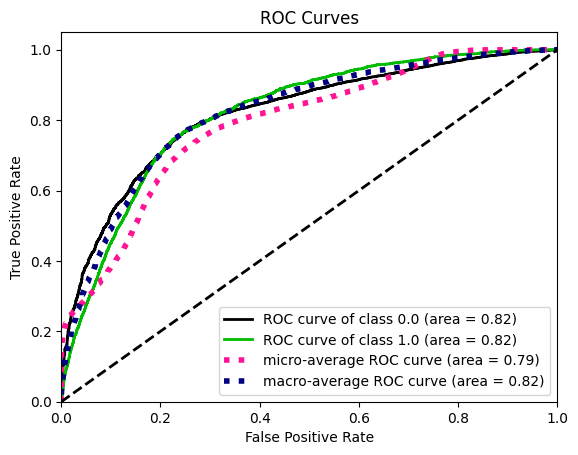

In [61]:
for key, value in results.items():
    print(key, ' - ', value)


# plot ROC curve
import scikitplot as skplt
import matplotlib.pyplot as plt
# 
# 
y_true = y_test # ground truth labels
y_probas = gs.predict_proba(X_test)# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()    

In [ ]:
'''models = {
    KNeighborsClassifier: {
        "n_neighbors" : list(range(1, 31)),
        "weights" : ["uniform", "distance"],
        "p" : [1, 2, 3],
        "algorithm": ["ball_tree", "kd_tree", "brute"]
    },
    DecisionTreeClassifier: {
        "criterion": ['gini', 'entropy', 'log_loss'],
        "splitter": ['best', 'random'],
        "max_depth": list(range(2, 12)),
        "min_samples_leaf": list(range(1, 25, 2)),
        "max_leaf_nodes": list((range(4, 25, 3)))
    },
    RandomForestClassifier: {
        "n_estimators": [10, 50, 100],
        "criterion": ['gini', 'entropy', 'log_loss'],
        "max_depth": list(range(2, 7)),
        "min_samples_leaf": list(range(1, 25, 2)),
        "max_leaf_nodes": list((range(4, 22, 3)))
    },
    LogisticRegression: {
        "tol": [10**i for i in range(1, -7, -1)],
        "C": [10**i for i in range(-4, 8, 1)],
        "max_iter": [1000, 10000, 100000],
        "l1_ratio": [i/10 for i in range(1, 9, 1)],
        "penalty": ['l1', 'l2', 'elasticnet'],
        "solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
    },
    SGDClassifier: {
        "tol": [10**i for i in range(1, -7, -1)],
        "max_iter": [1000, 10000, 100000]
    },
    ExtraTreesClassifier: {
        "criterion": ['gini', 'entropy', 'log_loss'],
        "max_depth": list(range(2, 12)),
        "min_samples_split": list(range(2, 25, 2)),
        "min_samples_leaf": list((range(4, 25, 3)))
    }
}'''

models = {
    BalancedRandomForestClassifier: {
       # "n_estimators": [],
        "criterion": ['gini', 'entropy'],
        "max_depth": list(range(2, 12)),
        "min_samples_split": list(range(2, 25, 2)),
        "min_samples_leaf": list((range(4, 25, 3))),
        "sampling_strategy": [0.6, 0.8, 1],
        "class_weight": ['balanced', 'balanced_subsample']
    }
}

# scalers = [MinMaxScaler, StandardScaler, '']
scalers = [MinMaxScaler]
samplers = [RandomUnderSampler, SMOTE]
sampling_strategies = [i*0.1 for i in range(1, 9, 2)]
length = len(models.keys()) * len(scalers) * len(samplers) * len(sampling_strategies)
i = 1
results = {}
confusions = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


for sampling_strategy in sampling_strategies:
    
    for sampler_ in samplers:
        sampler = sampler_(random_state=0, sampling_strategy=sampling_strategy)
        X_res, y_res = sampler.fit_resample(X_train, y_train)

        for scaler_ in scalers:
            if scaler_:
                scaler = scaler_()
                X_train_scaled = scaler.fit_transform(X_res)
                X_test_scaled = scaler.transform(X_test)
            else:
                X_test_scaled = X_test

            for model, params in models.items():
                print(f"Running model search number {i} out of {length}")
                i += 1
                # gs = GridSearchCV(estimator=model(), param_grid=params, scoring=['f1', 'accuracy', 'recall'], refit='f1', cv=5, verbose=1, n_jobs=-1)
                gs = RandomizedSearchCV(estimator=model(), param_distributions=params, scoring='roc_auc', refit='roc_auc', n_iter=15, cv=2, verbose=1, n_jobs=-1)
                gs.fit(X_train_scaled, y_res)
                tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test_scaled)).ravel()
                results[f"{str(gs.best_estimator_).split('(')[0]} - {scaler_} - {sampler_} - {sampling_strategy}"] = {'params': f'{gs.best_params_}', 'refit': f'{gs.best_score_}', 'roc_auc_test': f"{roc_auc_score(y_test, gs.predict_proba(X_test_scaled)[:, 1])}", 'tn': f'{tn}', 'fp': f'{fp}', 'fn': f'{fn}', 'tp': f'{tp}'}


for key, value in results.items():
    print(key, ' - ', value)

In [ ]:
# sns.heatmap(confusion_matrix(y_test, gs.predict(X_test_scaled)), square=True, annot=True, fmt='d', cbar=False)

In [ ]:
# sns.heatmap(confusion_matrix(y, gs.predict(X)), square=True, annot=True, fmt='d', cbar=False)

In [ ]:
# invoices.groupby('client_id').months_number.nunique().sort_values(ascending=False)

In [ ]:
# count_num = invoices.groupby('client_id').counter_number.nunique().sort_values(ascending=False).reset_index()

# merged = pd.merge(left=count_num, right=clients, on='client_id')
# merged.corr(numeric_only=True)

In [ ]:
# px.imshow(clients.corr(numeric_only=True), text_auto=True)

In [ ]:
# px.imshow(invoices.corr(numeric_only=True), text_auto=True, height=800, width=800)

In [ ]:
# df = pd.merge(left=invoices, right=clients, on='client_id', how='left')

In [ ]:
# df['counter_type_int'] = df.counter_type.map({'GAZ': 0, 'ELEC': 1})

In [ ]:
# df.sample()

In [ ]:
# px.imshow(df.corr(numeric_only=True), text_auto=True, width=1000, height=1000, color_continuous_scale='RdBu')

In [ ]:
# grouped = df.groupby(['target', 'client_id']).consommation_level_1.std().reset_index().groupby('target').consommation_level_1.mean()

# px.imshow(grouped.corr(numeric_only=True), text_auto=True, width=1000, height=1000)
# grouped


In [ ]:
# df['date'] = pd.to_datetime(df.invoice_date)